In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Composite Hilbert Spaces, QuTiP Interface

The `HilbertSpace` class provides data structures and methods for handling composite Hilbert spaces which may consist of multiple qubits or qubits and oscillators coupled to each other. To harness the power of QuTiP, a toolbox for studying stationary and dynamical properties of closed and open quantum systems (and much more), `HilbertSpace` provides a convenient interface: it generates `qutip.qobj` objects which are then directly handled by QuTiP.

In [2]:
import scqubits as qubit

import numpy as np

## Example: two transmons coupled to a harmonic mode

Transmon qubits can be capacitively coupled to a common harmonic mode, realized by an LC oscillator or a transmission-line resonator. The Hamiltonian describing such a composite system is given by:
\begin{equation}
H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}\sum_{j,k}g^{(\alpha)}_{jk} |\alpha j\rangle \langle \alpha k|(a+a^\dagger),
\end{equation}
where $\alpha=1,2$ enumerates the two transmon systems. The eigenenergies of the two transmon qubits are denoted $E_j^\alpha$, $\omega_r$ is the (angular) frequency of the resonator, and $g^{(\alpha)}_{jk} = g_\alpha \langle \alpha j | n_\alpha | \alpha k \rangle$ parametrizes the coupling between the qubits and the resonator.

### Create Hilbert space components

The first step consists of creating the objects describing the building blocks of the full Hilbert space. Here, these will be two transmons and an oscillator:

In [3]:
tmon1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

tmon2 = qubit.Transmon(
    EJ = 3.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)

The system objects are grouped into a Python list and in this form used for the creation and initialization of a `HilbertSpace` instance. Once created, an unqualified call to this instance outputs a summary of the composite Hilbert space.

In [4]:
hilbertspc = qubit.HilbertSpace([tmon1, tmon2, resonator])

hilbertspc

====== HilbertSpace object ======

Transmon qubit
 ———— PARAMETERS ————
truncated_dim	: 3
EJ	: 40.0
ng	: 0.3
EC	: 0.2
ncut	: 40
Hilbert space dimension	: 81

Transmon qubit
 ———— PARAMETERS ————
truncated_dim	: 4
EJ	: 3.0
ng	: 0.0
EC	: 1.0
ncut	: 10
Hilbert space dimension	: 21

Oscillator
 ———— PARAMETERS ————
omega	: 6.0
truncated_dim	: 4
Hilbert space dimension	: 4

### Set up the Hamiltonian in the composite Hilbert space

To convert the joint Hamiltonian (see above) into code, we require the Hamiltonians of the individual subsystems. `HilbertSpace.diag_hamiltonian(subsys)` looks up the eigenenergies of the subsystem `subsys`, constructs the corresponding diagonal Hamiltonian of that subsystem, and finally calculates the Kronecker product to lift the operator into the full composite Hilbert space.

In [5]:
# Define resonator Hamiltonian (full product Hilbert space)
hres = hilbertspc.diag_hamiltonian(resonator)

# Get diagonalized tmon1 and tmon2 Hamiltonians (full product Hilbert space)
h1 = hilbertspc.diag_hamiltonian(tmon1)
h2 = hilbertspc.diag_hamiltonian(tmon2)

 The resulting operators are provided in `qutip.qobj` format:

In [6]:
h1

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-36.05064983   0.           0.         ...   0.           0.
    0.        ]
 [  0.         -36.05064983   0.         ...   0.           0.
    0.        ]
 [  0.           0.         -36.05064983 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -20.67410141   0.
    0.        ]
 [  0.           0.           0.         ...   0.         -20.67410141
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  -20.67410141]]

To complete the construction of the full system Hamiltonian, the coupling Hamiltonian must still be constructed. This requires evaluation of the involved charge matrix elements entering the coupling parameters $g^{(\alpha)}_{jk} = g_\alpha \langle \alpha j | n_\alpha | \alpha k \rangle$:

In [7]:
g1 = 0.1  # coupling strength resonator-tmon1 (without charge matrix elements)
g2 = 0.2  # coupling strength resonator-tmon2 (without charge matrix elements)

dim1 = tmon1.truncated_dim
dim2 = tmon2.truncated_dim

_, evecs1 = tmon1.eigensys(dim1)
_, evecs2 = tmon2.eigensys(dim2)
gmat1 = g1 * qubit.get_matrixelement_table(tmon1.n_operator(), evecs1)   # coupling constants for tmon1
gmat2 = g2 * qubit.get_matrixelement_table(tmon2.n_operator(), evecs2)   # and for tmon2

In the coupling Hamiltonian, operators of the type $|\alpha j\rangle\langle \alpha k|$ appear. Such Hubbard operators are provided as `HilbertSpace.hubbard_operator(j,k,subsys)`. The same applies for the annihilation operator of the oscillator in the joint Hilbert space, obtained from `HilbertSpace.annihilate(subsys)`.

The following few lines construct the coupling Hamiltonian and then compose the full system Hamiltonian.

In [8]:
hbd = hilbertspc.hubbard_operator

v1 = sum([gmat1[j][k] * hbd(j,k,tmon1) for j in range(dim1) for k in range(dim1)])
v2 = sum([gmat2[j][k] * hbd(j,k,tmon2) for j in range(dim2) for k in range(dim2)])

a = hilbertspc.annihilate(resonator)

hamiltonian1 = (v1 + v2) * (a + a.dag())


hamiltonian0 = h1 + h2 + hres
hamiltonian = hamiltonian0 + hamiltonian1

### Obtaining eigenspectrum via QuTiP

Since `hamiltonian` is a proper qutip.qobj, all QuTiP routines are now available. For instance, here is how to obtain eigenenergies and eigenstates:

In [9]:
evals, evecs = hamiltonian.eigenstates()

evals[0:4]

array([-36.99001175, -32.24866076, -31.31265573, -31.00050268])

### Calculating spectra as a function of an external parameter

Consider flux-tuning one of the transmons, say transmon 1. In that case, its Josephson energy becomes flux-dependent: $E_{J1}\to E_{J1} \cos(\pi\Phi_\text{ext}/\Phi_0)$. We modify the definition of the Hamiltonian accordingly, making it a function of the reduced flux $\Phi_\text{ext}/\Phi_0$:

In [10]:
ham0 = h2 + hres  # partial Hamiltonian of transmon 2 and resonator


def hamiltonian(flux):
    tmon1.EJ = 40.0 * np.cos(np.pi*flux)
    h1 = hilbertspc.diag_hamiltonian(tmon1)
    v1 = sum([gmat1[j][k] * hbd(j,k,tmon1) for j in range(dim1) for k in range(dim1)])
    
    return (h1 + ham0 + (v1 + v2) * (a + a.dag()))

Once the list of desired flux values is generated, `HilbertSpace.get_spectrum_vs_paramvals` is available to obtain the scan of the spectrum over flux:

In [11]:
flux_list = np.linspace(-0.1, 0.6, 100)
specdata = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list, evals_count=15, get_eigenstates=True)


[====================] 100% Done.


The returned data are stored in a `SpecData` object. Here is how to inspect the eigenenergies for the third (indicing starts at 0) flux value:

In [12]:
specdata.energy_table[2]

array([-35.61671109, -30.87536252, -29.93935539, -29.62839549,
       -27.95521996, -24.89469034, -23.95779031, -23.64010506,
       -23.21389138, -22.27788515, -21.97003287, -20.49827277,
       -18.91372364, -18.6059474 , -17.97609201])

### Plotting an absorption spectrum

Spectroscopy experiments probe transition energies, not absolute energies. `HilbertSpace.absorption_spectrum` processes the calculated data `specdata` and provides absorption data. In the following example, all transition energies are relative to the ground state energy. The reference state may be given in bare-state form; here, we specify that we mean the state closest to the bare state with both transmons in the ground state, and no photon in the resonator:

In [13]:
absorptiondata = hilbertspc.absorption_spectrum(specdata, ((tmon1, 0), (tmon2, 0), (resonator, 0)), initial_as_bare=True)


[====================] 100% Done.


The returned data forms a new `SpecData` object and can be inspected as before:

In [14]:
absorptiondata.energy_table[5]

array([ 0.        ,  4.74134965,  5.67735584,  5.98885753,  7.72433769,
       10.72256393, 11.65946188, 11.97769128, 12.46566932, 13.40167469,
       13.71033934, 15.24395056, 16.7040735 , 17.01076372, 17.64170233])

The `SpecData` class provides built-in methods for plotting the energy data as a function of the scanned parameter:

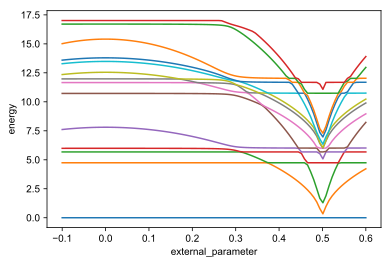

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x221c604fa90>)

In [15]:
absorptiondata.plot_evals_vs_paramvals()